🧩 Block 1 – Imports & Hyperparameters

In [12]:
# PORTBRAIN – DQN Ship Handling
# CSCN8020 – Reinforcement Learning

import random
import math
from collections import deque, namedtuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from tqdm import trange


In [13]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [14]:
# Hyperparameters

NUM_EPISODES        = 100          # as in progress report
MAX_STEPS_PER_EP    = 50           # max timesteps per episode

GAMMA               = 0.99
LR                  = 1e-3
BATCH_SIZE          = 64
REPLAY_CAPACITY     = 10_000

EPS_START           = 1.0
EPS_END             = 0.1
EPS_DECAY_EPISODES  = 80           # how quickly epsilon decays

TARGET_UPDATE_FREQ  = 10           # episodes
MAX_SHIPS_QUEUE     = 10           # max ships waiting in queue
MAX_HANDLE_PER_STEP = 3            # max ships agent can handle per step

TRAINING_HISTORY_CSV = "portbrain_training_history.csv"


🏗️ Block 2 – Port Environment Class

Simple custom environment:

State = [ships_waiting, ships_handled, timestep]

Actions = 0 … MAX_HANDLE_PER_STEP (how many ships to handle)

Reward:

+2 per ship handled

−1 per ship still waiting at the end of step

small −0.1 per step to encourage faster completion

In [15]:
class PortEnv:
    """
    Simple port environment for ship handling.
    - Ships arrive over time.
    - Agent decides how many ships to handle each step (0..MAX_HANDLE_PER_STEP).
    - Goal: handle all ships with high reward and fewer steps.
    """
    def __init__(self,
                 max_ships_queue=MAX_SHIPS_QUEUE,
                 max_handle_per_step=MAX_HANDLE_PER_STEP,
                 max_steps=MAX_STEPS_PER_EP,
                 arrival_rate=1.0):
        self.max_ships_queue = max_ships_queue
        self.max_handle_per_step = max_handle_per_step
        self.max_steps = max_steps
        self.arrival_rate = arrival_rate  # mean arrivals per step (Poisson)

        self.state_dim = 3  # ships_waiting, ships_handled, timestep
        self.action_dim = max_handle_per_step + 1  # actions 0..max_handle_per_step

        self.reset()

    def reset(self):
        # initial number of ships waiting (e.g., 3–7)
        self.ships_waiting = np.random.randint(3, 8)
        self.ships_handled = 0
        self.timestep = 0
        self.done = False

        return self._get_obs()

    def _get_obs(self):
        # Option 1: raw counts
        obs = np.array(
            [self.ships_waiting,
             self.ships_handled,
             self.timestep],
            dtype=np.float32
        )
        return obs

    def step(self, action: int):
        """
        Action = integer (0..max_handle_per_step)
        """
        if self.done:
            raise ValueError("Step called on terminated episode. Call reset().")

        self.timestep += 1

        # Clamp action to valid range
        action = int(action)
        action = max(0, min(action, self.max_handle_per_step))

        # Actual handled ships cannot exceed waiting ships
        ships_handled_now = min(action, self.ships_waiting)

        # Update ships
        self.ships_waiting -= ships_handled_now
        self.ships_handled += ships_handled_now

        # New ships may arrive (Poisson process)
        new_arrivals = np.random.poisson(self.arrival_rate)
        self.ships_waiting += new_arrivals
        self.ships_waiting = min(self.ships_waiting, self.max_ships_queue)

        # Reward design
        # +2 per ship handled this step
        # -1 per ship still waiting at end of step
        # -0.1 per step (time penalty)
        reward = 2.0 * ships_handled_now
        reward -= 1.0 * self.ships_waiting
        reward -= 0.1  # small time penalty

        # Termination condition
        if (self.ships_waiting == 0 and self.timestep > 0) or self.timestep >= self.max_steps:
            self.done = True

        obs = self._get_obs()
        return obs, reward, self.done, {
            "ships_waiting": self.ships_waiting,
            "ships_handled": self.ships_handled,
            "timestep": self.timestep,
            "new_arrivals": new_arrivals,
            "handled_this_step": ships_handled_now,
        }


In [16]:
env = PortEnv()
state = env.reset()
print("Initial state:", state)

for _ in range(5):
    a = np.random.randint(0, env.action_dim)
    next_state, reward, done, info = env.step(a)
    print(f"Action={a}, Next state={next_state}, Reward={reward:.2f}, Done={done}, Info={info}")
    if done:
        break


Initial state: [7. 0. 0.]
Action=2, Next state=[7. 2. 1.], Reward=-3.10, Done=False, Info={'ships_waiting': 7, 'ships_handled': 2, 'timestep': 1, 'new_arrivals': 2, 'handled_this_step': 2}
Action=2, Next state=[5. 4. 2.], Reward=-1.10, Done=False, Info={'ships_waiting': 5, 'ships_handled': 4, 'timestep': 2, 'new_arrivals': 0, 'handled_this_step': 2}
Action=2, Next state=[6. 6. 3.], Reward=-2.10, Done=False, Info={'ships_waiting': 6, 'ships_handled': 6, 'timestep': 3, 'new_arrivals': 3, 'handled_this_step': 2}
Action=1, Next state=[7. 7. 4.], Reward=-5.10, Done=False, Info={'ships_waiting': 7, 'ships_handled': 7, 'timestep': 4, 'new_arrivals': 2, 'handled_this_step': 1}
Action=3, Next state=[ 4. 10.  5.], Reward=1.90, Done=False, Info={'ships_waiting': 4, 'ships_handled': 10, 'timestep': 5, 'new_arrivals': 0, 'handled_this_step': 3}


💾 Block 3 – Replay Memory

In [17]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))


class ReplayMemory:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size: int):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


🧠 Block 4 – DQN Network & Agent

In [18]:
class DQN(nn.Module):
    def __init__(self, state_dim: int, action_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


In [19]:
class DQNAgent:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        gamma: float = GAMMA,
        lr: float = LR,
        replay_capacity: int = REPLAY_CAPACITY,
        batch_size: int = BATCH_SIZE,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size

        self.policy_net = DQN(state_dim, action_dim).to(device)
        self.target_net = DQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayMemory(replay_capacity)

        self.steps_done = 0
        self.eps_start = EPS_START
        self.eps_end = EPS_END
        self.eps_decay_episodes = EPS_DECAY_EPISODES

    def select_action(self, state: np.ndarray, episode_idx: int) -> int:
        """
        Epsilon-greedy action selection based on episode index.
        """
        eps = self._get_epsilon(episode_idx)

        if random.random() < eps:
            # Explore
            action = random.randrange(self.action_dim)
        else:
            # Exploit
            state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net(state_t)
                action = int(torch.argmax(q_values, dim=1).item())
        return action

    def _get_epsilon(self, episode_idx: int) -> float:
        # Linear decay from EPS_START to EPS_END over eps_decay_episodes
        frac = min(1.0, episode_idx / self.eps_decay_episodes)
        eps = self.eps_start + frac * (self.eps_end - self.eps_start)
        return eps

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return None  # not enough samples

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        # Convert to tensors
        state_batch = torch.tensor(np.stack(batch.state), dtype=torch.float32, device=device)
        action_batch = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
        next_state_batch = torch.tensor(np.stack(batch.next_state),
                                        dtype=torch.float32,
                                        device=device)
        done_batch = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

        # Current Q values: Q(s,a)
        q_values = self.policy_net(state_batch).gather(1, action_batch)

        # Next Q values: max_a' Q_target(s', a')
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).max(1, keepdim=True)[0]
            target_q_values = reward_batch + self.gamma * next_q_values * (1.0 - done_batch)

        # Loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        # Optional gradient clipping
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


🎯 Block 5 – Training Loop + Logging (CSV)

This block trains the agent and logs per-episode metrics similar to what you showed in your report:

Episode

Ships Handled

Reward

Steps

Avg Q-value (per step)

Epsilon

In [20]:
env = PortEnv()
agent = DQNAgent(
    state_dim=env.state_dim,
    action_dim=env.action_dim,
    gamma=GAMMA,
    lr=LR,
    replay_capacity=REPLAY_CAPACITY,
    batch_size=BATCH_SIZE,
)

episode_history = []  # list of dicts, will convert to DataFrame later


In [21]:
for ep in trange(NUM_EPISODES, desc="Training"):
    state = env.reset()
    done = False

    total_reward = 0.0
    steps = 0
    ships_handled_final = 0
    q_values_list = []

    eps = agent._get_epsilon(ep)

    while not done and steps < MAX_STEPS_PER_EP:
        steps += 1

        # Choose action
        action = agent.select_action(state, episode_idx=ep)

        # For logging Q-values (optional)
        with torch.no_grad():
            state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            q_vals = agent.policy_net(state_t).cpu().numpy()[0]
            q_values_list.append(float(np.max(q_vals)))

        # Step in environment
        next_state, reward, done, info = env.step(action)

        total_reward += reward
        ships_handled_final = info["ships_handled"]

        # Store transition
        agent.memory.push(state, action, reward, next_state, float(done))

        # Optimize
        loss = agent.optimize_model()

        # Move to next state
        state = next_state

    # Update target network periodically
    if (ep + 1) % TARGET_UPDATE_FREQ == 0:
        agent.update_target_network()

    avg_q = float(np.mean(q_values_list)) if len(q_values_list) > 0 else 0.0

    episode_history.append({
        "episode": ep + 1,
        "ships_handled": ships_handled_final,
        "reward": total_reward,
        "steps": steps,
        "avg_q_value": avg_q,
        "epsilon": eps,
    })

    # Simple console log every 10 episodes
    if (ep + 1) % 10 == 0:
        print(f"[Episode {ep+1}] "
              f"Ships handled={ships_handled_final} | "
              f"Reward={total_reward:.1f} | Steps={steps} | "
              f"AvgQ={avg_q:.2f} | Eps={eps:.3f}")


Training:   0%|          | 0/100 [00:00<?, ?it/s]

[Episode 10] Ships handled=4 | Reward=6.8 | Steps=2 | AvgQ=0.38 | Eps=0.899

Training:  12%|█▏        | 12/100 [00:00<00:01, 68.75it/s]

Training:  24%|██▍       | 24/100 [00:00<00:02, 31.37it/s]

[Episode 20] Ships handled=11 | Reward=-6.7 | Steps=7 | AvgQ=4.10 | Eps=0.786


Training:  36%|███▌      | 36/100 [00:01<00:01, 32.34it/s]

[Episode 30] Ships handled=9 | Reward=8.7 | Steps=3 | AvgQ=5.80 | Eps=0.674


Training:  44%|████▍     | 44/100 [00:01<00:01, 33.29it/s]

[Episode 40] Ships handled=14 | Reward=14.1 | Steps=9 | AvgQ=5.15 | Eps=0.561


Training:  54%|█████▍    | 54/100 [00:01<00:01, 37.70it/s]

[Episode 50] Ships handled=6 | Reward=5.7 | Steps=3 | AvgQ=7.44 | Eps=0.449


Training:  64%|██████▍   | 64/100 [00:01<00:00, 40.23it/s]

[Episode 60] Ships handled=5 | Reward=7.7 | Steps=3 | AvgQ=7.48 | Eps=0.336
[Episode 70] Ships handled=6 | Reward=4.7 | Steps=3 | AvgQ=11.40 | Eps=0.224


Training:  93%|█████████▎| 93/100 [00:02<00:00, 58.18it/s]

[Episode 80] Ships handled=6 | Reward=8.7 | Steps=3 | AvgQ=11.57 | Eps=0.111
[Episode 90] Ships handled=5 | Reward=6.7 | Steps=3 | AvgQ=12.34 | Eps=0.100


Training: 100%|██████████| 100/100 [00:02<00:00, 41.82it/s]

[Episode 100] Ships handled=12 | Reward=13.4 | Steps=6 | AvgQ=13.56 | Eps=0.100


In [22]:
# Save training history to CSV
history_df = pd.DataFrame(episode_history)
history_df.to_csv(TRAINING_HISTORY_CSV, index=False)
history_df.head()

,episode,ships_handled,reward,steps,avg_q_value,epsilon
0,1,13,-22.5,15,0.619705,1.00000
1,2,21,-43.7,17,0.835565,0.98875
2,3,10,-4.7,7,0.492114,0.97750
3,4,10,11.5,5,0.411047,0.96625
4,5,4,6.8,2,0.247603,0.95500


📈 Block 6 – Quick Visualization

You can adjust or extend this for your report.

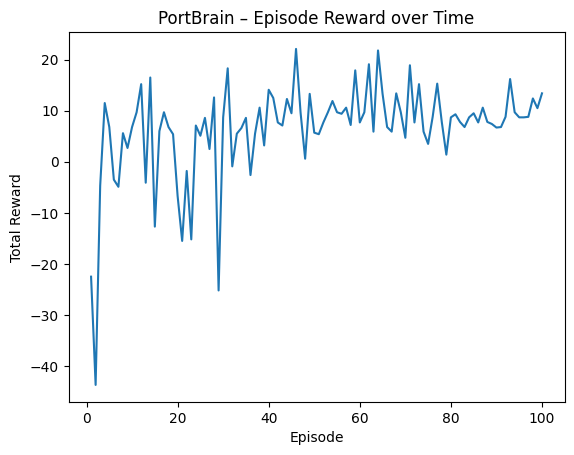

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_df["episode"], history_df["reward"])
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PortBrain – Episode Reward over Time")
plt.show()


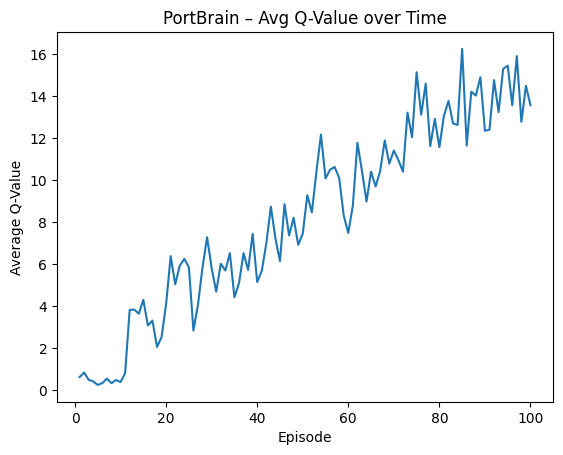

In [24]:
plt.figure()
plt.plot(history_df["episode"], history_df["avg_q_value"])
plt.xlabel("Episode")
plt.ylabel("Average Q-Value")
plt.title("PortBrain – Avg Q-Value over Time")
plt.show()


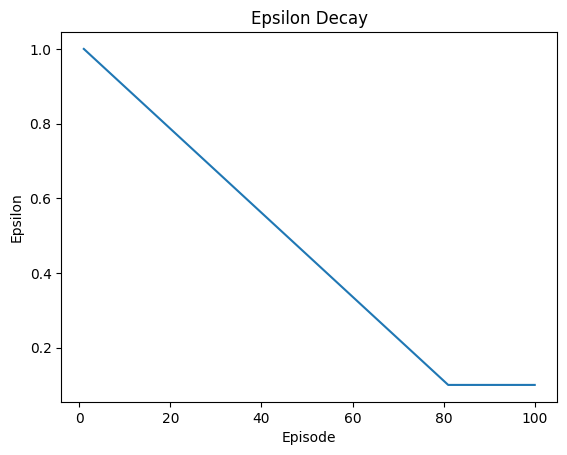

In [25]:
plt.figure()
plt.plot(history_df["episode"], history_df["epsilon"])
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()
